# DiD Role of Autocorrelation
Julian Hsu
31 january 2023

While panel methods, specifically DiD, are highly sought after causal tools because their validity can be tested, one drawback is that they can require a lot of data. They require a panel dataset where units are observed over time. This can place a large burden on data anlyses and potential turnoff their use.

This script's objective is to study how autocorrelation / serial correlation in units interacts with DiD setup.

**18mar2023 update** let's just look at the relationship between bias and AR. Increasing the trend size is complicated by how many periods we have to start out with, and the effect size is also complicated with AR.

**Soundbyte**: Bias-variance trade-off for difference-in-difference models.

Most causal analyses are done by comparing how treated units' outcomes change over time compared to other units'. This is known as difference-in-difference (DiD) models. I show that the more path dependent (aka more serially correlated) units' outcomes are over, naive implementations will yield higher biases. This is because DiD models cannot tell outcomes change because of the trend or from the path dependency. 

A good (!) common solution is to control for lagged outcomes to distinguish this. However, as the treatment effect increases, the bias from controlling for lags actually gets bigger. It is very unlikely you will run into this scenario. Therefore, controling for lagged outcomes is a good common practice.

Check out the simulation notebook [here](url), which also describes the bias-variance trade-off involves with these analyses.

1. [Bias] When units' outcomes are highly correlated over time (aka high serial-correlation), then you will have more bias in your estimate. This is because the model cannot distinguish the treatment effect from unit-specific serial-correlation.
2. [Bias] Controlling for the lagged outcomes only works when your treatment effect is similar in magnitude to serial correlation. As the treatment effect increases, the bias from controlling for lags actually gets bigger. It is very unlikely you will run into this scenario. Therefore, general recommendation is to control for lagged outcomes.
    1. Note in simulations noise has a variance of 1, so the left most is where they are of equal magnitude.
3. [Variance] When treatment effects are small, it is better to control for lagged outcomes. Sometimes when auto-correlation is low, you get better precision.

In [183]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [196]:
'''

Generate a dataset where the series of outcomes are correlated over time.
We all at least one pre-treatment period, and only one post-treatment period.
We also only treat one unit.

'''

def data_with_ar(ar=0, preT=20, atet=0, N=5):
    initial_x = np.random.normal(0,0.5,N) 
    x_old = np.random.normal(0,1,N)
    output_df = pd.DataFrame(data={'y':x_old+initial_x, 'unit': np.arange(N), 'time':np.zeros(N)})
    
    assert (preT > 7),'Need at least two pre-treatment periods'
    
    ## Create an series of outcomes that are correlated over time.
    ## Make sure to add the treatment effect starting now
    for t in range(preT):
        treated_unit = (np.arange(N)==0)
        treatment_time = (t >= preT-5)
        if t==0:
            pass
        else:
            x_new = 2*initial_x - np.sin(t) + x_old*(ar) + np.random.normal(0,1,N)*(1-ar)
            add_df = pd.DataFrame(data={'y':x_new, 'unit': np.arange(N), 'time':np.ones(N)*t})
            add_df['treated'] = 0
            add_df.loc[treated_unit, 'treated']=1
            add_df['post']=treatment_time
            add_df.loc[ (add_df['treated']==1)&(add_df['post']==1), 'y'] += atet
            output_df = pd.concat([output_df,
                add_df])
            x_old = x_new[:]
    ## Only allow one unit to be treated    
    ## Do the last five units are the post period
    x_new = x_old*(ar) + np.random.normal(0,1,N)*(1-ar) + np.random.normal(0,1,N)
    output_df = pd.concat([output_df,
        pd.DataFrame(data={'y':x_new, 'unit': np.arange(N), 'time':np.ones(N)*t+1})])
#     output_df['treated'] = 0
#     output_df['post'] = 0
# #     output_df.loc[ (output_df['unit']==0) & (output_df['time']>=preT-5) , 'y'] += atet
#     output_df.loc[ (output_df['unit']==0) , 'treated'] =1
    
#     output_df.loc[ (output_df['time'] >= preT-5) , 'post'] =1
    output_df['post_x_treat'] = output_df['treated']*output_df['post']
    return output_df

    

In [197]:
'''
Simple DiD, putting inference aside.
'''
def did_simp(data=None):
    ## Pre-treatment, control
    pre_c = data.loc[(data['treated']==0) & (data['post']==0)]['y'].mean()
    ## Pre-treatment, treat
    pre_t = data.loc[(data['treated']==1) & (data['post']==0)]['y'].mean()
    
    ## Post-treatment, control
    pst_c = data.loc[(data['treated']==0) & (data['post']==1)]['y'].mean()
    ## Post-treatment, treat
    pst_t = data.loc[(data['treated']==1) & (data['post']==1)]['y'].mean()
    
    ## simple atet estimate
    atet_est = (pst_t - pst_c) - (pre_t - pre_c)
    return atet_est
'''
Let's have a more flexible DiD, allowing us to potentially use a lagged outcome.
'''
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

def did_twfe(data=None, lag=False):
    try:
        data.set_index(['unit','time'],inplace=True)
    except:
        pass
    if lag==False:
        XX=sm.add_constant(data['post_x_treat'])
    else:
        XX=sm.add_constant(pd.concat([data['post_x_treat'],data.groupby(['unit'])['y'].shift() ],axis=1) )
    # Model
    m = PanelOLS(dependent=data['y'],
                 exog=XX,
                 entity_effects=True,
                 time_effects=True)
    res=m.fit(cov_type='clustered', cluster_entity=True)    
    return res.params['post_x_treat'], res.std_errors['post_x_treat']


In [198]:
N = 50
preT = 10
atet=10
ar = 0.8

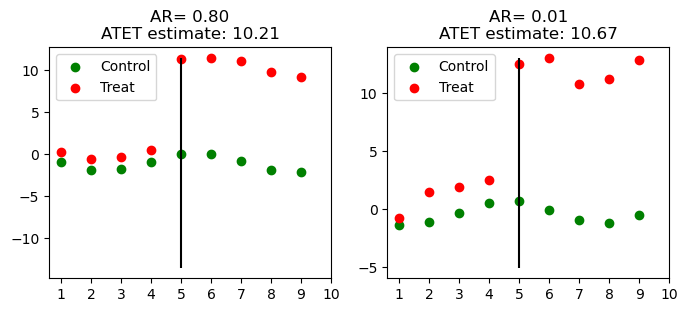

In [200]:
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(8,3))

df = data_with_ar(ar=0.8, preT=10, atet=atet, N=N)
plot_control = df.loc[df['treated']==0].groupby('time')['y'].mean()
plot_treat = df.loc[df['treated']==1].groupby('time')['y'].mean()
ax[0].scatter(x = plot_control.index, y=plot_control, color='green', label='Control')
ax[0].scatter(x = plot_treat.index, y=plot_treat, color='red', label='Treat')
ax[0].vlines(x = preT-5, ymax=df['y'].max(), ymin=df['y'].min() , color='black')
ax[0].legend()
ax[0].set_xticks(np.arange(1,preT+1))
ax[0].set_xticklabels(np.arange(1,preT+1))
ax[0].set_title('AR={1:5.2f}\nATET estimate: {0:5.2f}'.format( did_simp(data=df), 0.8) )

df = data_with_ar(ar=0.01, preT=10, atet=atet, N=N)
plot_control = df.loc[df['treated']==0].groupby('time')['y'].mean()
plot_treat = df.loc[df['treated']==1].groupby('time')['y'].mean()
ax[1].scatter(x = plot_control.index, y=plot_control, color='green', label='Control')
ax[1].scatter(x = plot_treat.index, y=plot_treat, color='red', label='Treat')
ax[1].vlines(x = preT-5, ymax=df['y'].max(), ymin=df['y'].min() , color='black')
ax[1].legend()
ax[1].set_xticks(np.arange(1,preT+1))
ax[1].set_xticklabels(np.arange(1,preT+1))
ax[1].set_title('AR={1:5.2f}\nATET estimate: {0:5.2f}'.format( did_simp(data=df), 0.01) )


plt.show()


For different auto-correlation values, calculate the atet and bias.
Also run a few bootstraps to rule out simulation noise.
In order to fully deep dive the simulations, record the individual result from each simulation.

In [201]:
atet_list = []
ar_list = [0.01,0.20,0.40,0.60,0.80]
pret_list = [2,5,10]
## Ground truth is in terms of standard deviations of the initial period
true_gt = [1,2.5, 5]

sim_number = 100
t = 10

import warnings
warnings.filterwarnings("ignore")

sim_results = pd.DataFrame()
for gt in true_gt:
    for a in ar_list:
        atet_sim = []
        est_ar_list = []
        for s in range(sim_number):
            df = data_with_ar(ar=a, preT=t, atet=gt, N=50)
            atet_est=did_twfe(data=df, lag=False)
            sim_results = pd.concat([sim_results, 
                                            pd.DataFrame(index=[s],data={'lag':False, 'ar':a,
                                                                         'pret':t, 
                                                                         'gt':gt,
                                                                         'se':atet_est[1],
                                                                         'atet':atet_est[0], 'bias': np.abs(atet_est[0]- gt),
                                                                        'mape': 100*np.abs(atet_est[0] - gt)/gt})])

            atet_est_l=did_twfe(data=df, lag=True)
            sim_results = pd.concat([sim_results, 
                                            pd.DataFrame(index=[s],data={'lag':True, 'ar':a,
                                                                         'pret':t, 
                                                                         'gt':gt,
                                                                         'se':atet_est_l[1],
                                                                         'atet':atet_est_l[0], 'bias': np.abs(atet_est_l[0]- gt),
                                                                        'mape': 100*np.abs(atet_est_l[0] - gt)/gt})])


In [202]:
display( sim_results.groupby(['gt','ar','lag'])[['atet','bias','se',]].describe().T )

gt                 1.0                                                  \
ar                0.01                    0.20                    0.40   
lag              False        True       False        True       False   
atet count  100.000000  100.000000  100.000000  100.000000  100.000000   
     mean     1.041467    1.124201    0.951067    0.879958    0.969926   
     std      0.738769    0.779561    0.652065    0.607683    0.615097   
     min     -0.878012   -1.019998   -0.671746   -0.658614   -0.591156   
     25%      0.542129    0.603688    0.479813    0.442428    0.546661   
     50%      0.969966    1.123277    0.901289    0.812594    0.959272   
     75%      1.512340    1.596658    1.390934    1.320554    1.425793   
     max      2.885664    3.000908    2.574029    2.351131    2.068981   
bias count  100.000000  100.000000  100.000000  100.000000  100.000000   
     mean     0.583742    0.624397    0.527953    0.507917    0.509811   
     std      0.450911    0.479049    0.382175    0.351068    0.341650   
     min      0.003690    0.054484    0.006011    0.015377    0.004823   
     25%      0.238911    0.231704    0.205093    0.243475    0.238797   
     50%      0.493006    0.487992    0.475133    0.472914    0.447078   
     75%      0.848810    0.933060    0.794083    0.745324    0.715930   
     max      1.885664    2.019998    1.671746    1.658614    1.591156   
se   count  100.000000  100.000000  100.000000  100.000000  100.000000   
     mean     0.100663    0.122573    0.094757    0.099025    0.093554   
     std      0.011508    0.018796    0.010181    0.016150    0.008808   
     min      0.063690    0.084325    0.071657    0.069127    0.068477   
     25%      0.092816    0.110094    0.087086    0.088220    0.090305   
     50%      0.101322    0.121798    0.095343    0.096293    0.094244   
     75%      0.108468    0.134868    0.101203    0.107617    0.098877   
     max      0.121384    0.175055    0.122292    0.152542    0.118907   

gt                                                                      ...  \
ar                            0.60                    0.80              ...   
lag               True       False        True       False        True  ...   
atet count  100.000000  100.000000  100.000000  100.000000  100.000000  ...   
     mean     0.706753    1.050549    0.520968    1.136359    0.296395  ...   
     std      0.423876    0.920526    0.271847    1.842412    0.135000  ...   
     min     -0.436257   -1.798230   -0.039108   -2.845000   -0.131524  ...   
     25%      0.440943    0.328010    0.321721   -0.345783    0.226213  ...   
     50%      0.730583    1.094352    0.503664    1.228293    0.305930  ...   
     75%      0.998828    1.576358    0.698561    2.277390    0.376284  ...   
     max      1.531493    3.226224    1.226617    5.562961    0.600614  ...   
bias count  100.000000  100.000000  100.000000  100.000000  100.000000  ...   
     mean     0.410951    0.736420    0.492626    1.475788    0.703605  ...   
     std      0.309752    0.549687    0.246087    1.101506    0.135000  ...   
     min      0.002923    0.026382    0.025525    0.066414    0.399386  ...   
     25%      0.200593    0.313288    0.301439    0.626193    0.623716  ...   
     50%      0.341087    0.663751    0.496336    1.319418    0.694070  ...   
     75%      0.559057    1.012170    0.678279    1.935789    0.773787  ...   
     max      1.436257    2.798230    1.039108    4.562961    1.131524  ...   
se   count  100.000000  100.000000  100.000000  100.000000  100.000000  ...   
     mean     0.080556    0.135544    0.053581    0.289758    0.026417  ...   
     std      0.018261    0.012612    0.014393    0.029510    0.009151  ...   
     min      0.051488    0.104239    0.034123    0.225411    0.017080  ...   
     25%      0.067032    0.126339    0.043358    0.270496    0.020516  ...   
     50%      0.076292    0.135466    0.050463    0.290319    0.023822  ...   
     75%      0.091189    

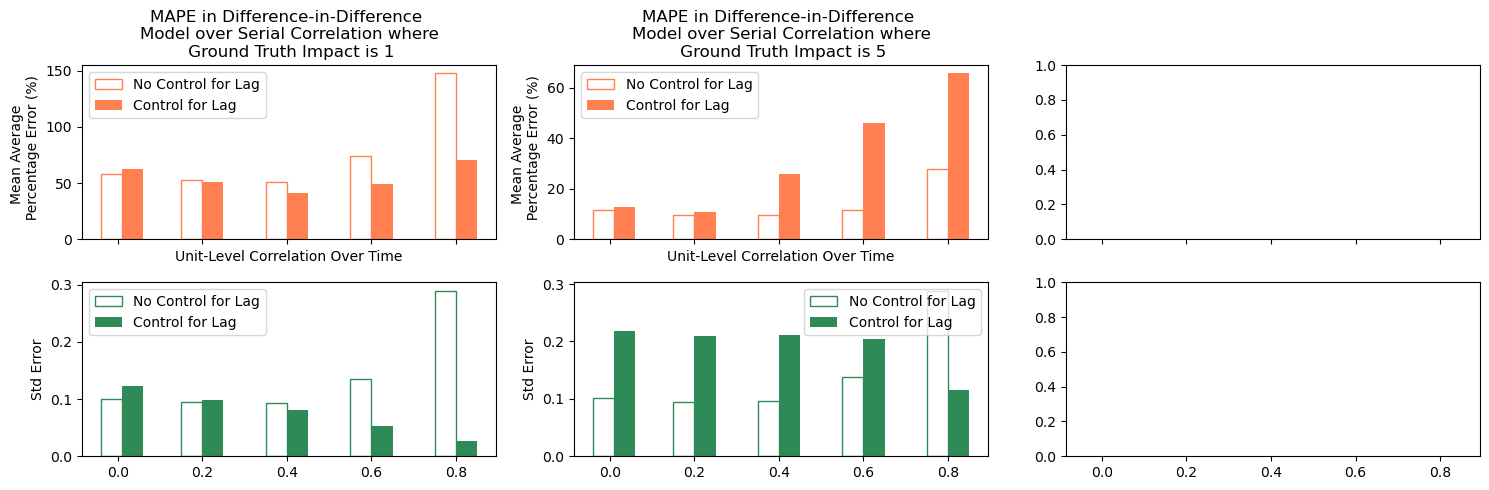

In [210]:
fig, ax = plt.subplots(ncols=len(true_gt),nrows=2, figsize=(5*len(true_gt), 5), sharex=True)         # Sample figsize in inches
for e in enumerate([1,5]):
    disp_data=sim_results.loc[sim_results['lag']==False].groupby(['gt','ar'])[['atet','bias','mape','se']].mean().reset_index() 
    ax[0,e[0]].bar(x=disp_data.loc[disp_data['gt']==e[1]]['ar']-0.025,
                   fill=False,
             height=disp_data.loc[disp_data['gt']==e[1]]['mape'],
          width=0.05, edgecolor='coral', label='No Control for Lag')
    ax[1,e[0]].bar(x=disp_data.loc[disp_data['gt']==e[1]]['ar']-0.025,
                   fill=False,
             height=disp_data.loc[disp_data['gt']==e[1]]['se'],
          width=0.05, edgecolor='seagreen', label='No Control for Lag')
    
    
    disp_data=sim_results.loc[sim_results['lag']==True].groupby(['gt','ar'])[['atet','bias','mape','se']].mean().reset_index() 
    ax[0,e[0]].bar(x=disp_data.loc[disp_data['gt']==e[1]]['ar']+0.025,
             height=disp_data.loc[disp_data['gt']==e[1]]['mape'],
          width=0.05, color='coral', label='Control for Lag')
    ax[1,e[0]].bar(x=disp_data.loc[disp_data['gt']==e[1]]['ar']+0.025,
             height=disp_data.loc[disp_data['gt']==e[1]]['se'],
          width=0.05, color='seagreen', label='Control for Lag')
        
    ax[0,e[0]].set_ylabel('Mean Average \n  Percentage Error (%)')
    ax[1,e[0]].set_ylabel('Std Error')
    ax[0,e[0]].set_xlabel('Unit-Level Correlation Over Time')
    ax[0,e[0]].set_title('MAPE in Difference-in-Difference \nModel over Serial Correlation where\n Ground Truth Impact is {0}'.format(e[1]))
    ax[0,e[0]].legend()
    ax[1,e[0]].legend()

plt.tight_layout()
plt.show()




In [146]:
# '''
# Look at how bias varies over these different dimensions with heatmaps.
# '''
# fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(4.5*1, 4))         # Sample figsize in inches

# import seaborn as sns
# mape_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='lag', aggfunc='mean', values=['mape'])

# sns.heatmap(mape_heatmap,
# #             xticklabels = [ np.round(e,2) for e in ar_list],
#            xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
#             cmap=sns.light_palette("coral", as_cmap=True) )
# ax.set_xlabel('AR Correlation over Time')
# ax.set_ylabel('Ground Truth Impact')
# ax.set_title('MAPE of ATET Estimates')

# plt.show()
# plt.tight_layout()